In [0]:
#importing the good old libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from tqdm import tqdm_notebook
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['sample_submission.csv', 'test.csv', 'train.csv']


In [0]:
# importing the dataset
df=pd.read_csv("../input/train.csv")

In [0]:
# printing the shape of our dataset
df.shape

(42000, 785)

In [0]:
# Converting to numpy array
X=df.iloc[:,1:].values
Y=df.iloc[:,0].values

In [0]:
print(X.shape)
print(Y.shape)

(42000, 784)
(42000,)


In [0]:
df.iloc[:,0].value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

In [0]:
# Splitting into Training and Validation datasets 

from sklearn.model_selection import train_test_split
X_train,X_val,Y_train,Y_val=train_test_split(X,Y,test_size=0.2,stratify=Y,random_state=0)
print(X_train.shape,X_val.shape,Y_train.shape,Y_val.shape)

(33600, 784) (8400, 784) (33600,) (8400,)


In [0]:
# One hot encoding the data

OH=OneHotEncoder()
Y_OH_train=OH.fit_transform(Y_train.reshape(-1,1)).toarray()
Y_OH_val=OH.transform(Y_val.reshape(-1,1)).toarray()

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [0]:
#StandardScaling the data

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)

In [0]:
print(X_train[:5,:5])

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [0]:
print(Y_OH_train.shape)
print(Y_OH_val.shape)

(33600, 10)
(8400, 10)


# Creating the Feedforward class

In [0]:
class FFSN_MultiClass_Generic:
  
    def __init__(self, n_inputs, n_outputs, hidden_sizes=[3],leaky_slope=0.1):
        self.nx = n_inputs
        self.ny = n_outputs
        self.nh = len(hidden_sizes)
        self.sizes = [self.nx] + hidden_sizes + [self.ny] 
        self.leaky_slope=leaky_slope

        self.W = {}
        self.B = {}
        self.v_w={}
        self.m_w={}
        self.v_b={}
        self.m_b={}
        for i in range(self.nh+1):
            self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])/np.sqrt(self.sizes[i])# Xavier Initialization
            self.m_w[i+1]=np.zeros((self.sizes[i], self.sizes[i+1]))
            self.v_w[i+1]=np.zeros((self.sizes[i], self.sizes[i+1]))
            self.B[i+1] = np.zeros((1, self.sizes[i+1]))
            self.m_b[i+1] = np.zeros((1, self.sizes[i+1]))
            self.v_b[i+1] = np.zeros((1, self.sizes[i+1]))

    def sigmoid(self, X):
        return 1.0/(1.0 + np.exp(-X))
    
    def leakyRelu(self,X):
        return np.maximum(self.leaky_slope*X,X)

    def softmax(self, X):
        exps = np.exp(X)
        return exps / np.sum(exps,axis=1).reshape(-1,1)

    def forward_pass(self, X):
        self.A = {}
        self.H = {}
        self.H[0]=X
#         print("H[0]:",X)
        for i in range(self.nh):
            self.A[i+1] = np.matmul(self.H[i], self.W[i+1]) + self.B[i+1]
#             print("A[1]:",self.A[1][:2,:])
            self.H[i+1] = self.sigmoid(self.A[i+1])
#             print("H[1]:",self.H[1][:2,:])
        self.A[self.nh+1] = np.matmul(self.H[self.nh], self.W[self.nh+1]) + self.B[self.nh+1]
#         print("A[2]:",self.A[2][:2,:])
        self.H[self.nh+1] = self.softmax(self.A[self.nh+1])
#         print("H[2]:",self.H[2][:2,:])
#         print("softmax sum",np.sum(self.H[2][:2,:],1))
#         print("y_hat:",self.H[self.nh+1].shape)
        return self.H[self.nh+1]

    def predict(self, X):
        y_pred = self.forward_pass(X)
        return np.array(y_pred).squeeze()

    def grad_sigmoid(self, X):
        return X*(1-X) 
    
    def grad_Relu(self,X):
        return 1*(X>0)
    
    def grad_leakyRelu(self,X):
        d=np.zeros_like(X)
        d[d<=0]=self.leaky_slope
        d[d>0]=1
        return d
    
    def cross_entropy(self,label,pred):
        yl=np.multiply(pred,label)
        yl=yl[yl!=0]
        yl=-np.log(yl)
        yl=np.mean(yl)
        return yl

    def grad(self, X, Y):
        self.forward_pass(X)
        self.dW = {}
        self.dB = {}
        self.dH = {}
        self.dA = {}
#         self.H[0]=X
        L = self.nh + 1
        self.dA[L] = (self.H[L] - Y)
        for k in range(L, 0, -1):
#             print("H["+str(k-1)+"]:",self.H[k-1][:2,:])
            self.dW[k] = np.matmul(self.H[k-1].T, self.dA[k])
#             print("dW["+str(k)+"]:",self.dW[k][:2,:])
            self.dB[k] = np.sum(self.dA[k],axis=0).reshape(1,-1)
#             print("dB["+str(k)+"]:",self.dB[k][:2,:])
            self.dH[k-1] = np.matmul(self.dA[k], self.W[k].T)#calculating dH[0] unnecessary
#             print("dH["+str(k-1)+"]:",self.dH[k-1][:2,:])
            self.dA[k-1] = np.multiply(self.dH[k-1], self.grad_sigmoid(self.H[k-1])) 
#             print("dA["+str(k-1)+"]:",self.dA[k-1][:2,:])
            
            

    def fit(self, X, Y, epochs=100, initialize=True, learning_rate=0.01, display_loss=False, beta1=0.9, beta2=0.9,eps=0.01):

        if display_loss:
            loss = {}

        if initialize:
            for i in range(self.nh+1):
                self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])/np.sqrt(self.sizes[i])# Xavier Initialisation
                self.B[i+1] = np.zeros((1, self.sizes[i+1]))

        for epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
#             print("X:",X.shape)
            self.grad(X, Y)
            m = X.shape[1]
            
            num_updates=0
            for i in range(self.nh+1):
                num_updates+=1
                self.m_w[i+1]= beta1 *self.m_w[i+1]+ (1-beta1)* self.dW[i+1]/m
                self.v_w[i+1]= beta2 *self.v_w[i+1]+ (1-beta2)* (self.dW[i+1]/m)**2
                
                m_w_hat=self.m_w[i+1]/(1+np.power(beta1,num_updates))
                v_w_hat=self.v_w[i+1]/(1+np.power(beta2,num_updates))
                
                self.W[i+1] -= (learning_rate/(np.sqrt(v_w_hat)+ eps)) * m_w_hat
#                 print("W1,2:",self.W[i+1][:2,:])
                
                self.m_b[i+1]= beta1 *self.m_b[i+1]+ (1-beta1)* self.dB[i+1]/m
                self.v_b[i+1]= beta2 *self.v_b[i+1]+ (1-beta2)* (self.dB[i+1]/m)**2
                
                m_b_hat=self.m_b[i+1]/(1+np.power(beta1,num_updates))
                v_b_hat=self.v_b[i+1]/(1+np.power(beta2,num_updates))
                
                self.B[i+1] -= (learning_rate/(np.sqrt(v_b_hat)+ eps)) * m_b_hat

            if display_loss:
                Y_pred = self.predict(X) 
                loss[epoch] = self.cross_entropy(Y, Y_pred)

        if display_loss:
          plt.plot(loss.values())
          plt.xlabel('Epochs')
          plt.ylabel('CE')
          plt.show()

In [0]:
Y_OH_train.shape

(33600, 10)

In [0]:
X_train.dtype

dtype('float64')

In [0]:
X_train.shape

(33600, 784)

# **Creating the object of our class and calling the fit function**

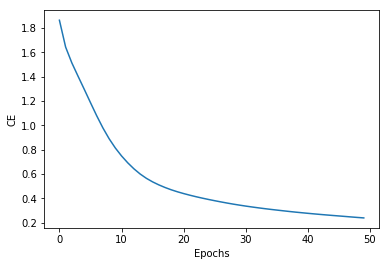

In [0]:
ff= FFSN_MultiClass_Generic(X_train.shape[1],Y_OH_train.shape[1],[15])
ff.fit(X_train, Y_OH_train, epochs=50,learning_rate=0.1,display_loss=True)

# **Evaluation**

In [0]:
Y_pred_train = ff.predict(X_train)
print(Y_pred_train.dtype)
Y_pred_train = np.argmax(Y_pred_train,1)

Y_pred_val = ff.predict(X_val)
Y_pred_val = np.argmax(Y_pred_val,1)

accuracy_train = accuracy_score(Y_pred_train, Y_train)
accuracy_val = accuracy_score(Y_pred_val, Y_val)
print("Training accuracy", round(accuracy_train, 2))
print("Validation accuracy", round(accuracy_val, 2))

float64
Training accuracy 0.93
Validation accuracy 0.9


In [0]:
Y_pred_train.dtype

dtype('int64')

In [0]:
print(ff.H[0].shape, ff.W[1].shape, ff.A[1].shape,ff.H[1].shape,ff.A[2].shape,ff.H[2].shape)

(8400, 784) (784, 15) (8400, 15) (8400, 15) (8400, 10) (8400, 10)


# **Creating the confusion matrix for better insights**

In [0]:
cm=confusion_matrix(Y_val,Y_pred_val)
cm

array([[786,   0,   5,   2,   4,  13,  11,   1,   4,   0],
       [  0, 902,   5,   3,   2,   0,   4,   5,  15,   1],
       [  7,   6, 719,  27,  10,   4,  20,  10,  25,   7],
       [  3,   2,  40, 746,   2,  28,   0,  17,  22,  10],
       [  1,   1,   7,   0, 761,   3,  12,   3,   1,  25],
       [ 14,   1,   8,  36,   2, 638,  13,   1,  30,  16],
       [ 19,   4,  10,   0,   1,  14, 774,   1,   5,   0],
       [  4,   4,  15,   7,  10,   4,   2, 806,   4,  24],
       [  8,  13,  18,  14,   7,  38,   5,   6, 684,  20],
       [  3,   1,   2,  10,  40,   6,   1,  38,   4, 733]])

# **Importing the test data**

In [0]:
df_test=pd.read_csv("../input/test.csv")
X_test=df_test.values
X_test=sc.transform(X_test)

# **Applying our model to the test data for submission**

In [0]:
Y_pred_test=ff.predict(X_test)
Y_pred_test = np.argmax(Y_pred_test,1)

submission = {}
submission['ImageId'] = np.array(range(1,X_test.shape[0]+1))
submission['Label'] = Y_pred_test

submission = pd.DataFrame(submission)
submission = submission[['ImageId', 'Label']]
submission = submission.sort_values(['ImageId'])
submission.to_csv("submisision.csv", index=False)